In [0]:
import numpy as np              #numpy library is used to work with multidimensional array.
import pandas as pd             #panda used for data manipulation and analysis.                
import os                       #os library is used for loading file to use in the program
import json                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path        #support path
import matplotlib.pyplot as plt #support ploting a figure
from matplotlib import colors   #colors support converting number or argument into colors
from tqdm.notebook import tqdm
from torch import FloatTensor, LongTensor
import torch
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
from torch.optim import Adam
import torch.nn as nn

In [0]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
# get the path for training_task, evaluation_task, and test_task
data_path = Path('./data')
#data_path = Path('Final_data/Final_data/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

#from the path above, we load the tests file's directory into our training_tasks, evaluation_tasks, and test_tasks variables
#the sorted() function is just for the list of directory to maintain some order
training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
test_tasks = sorted(os.listdir(test_path))

#Get the first file of the training_tasks
training_task_file = str(training_path / training_tasks[0])

#Get the first file of the evaluation_tasks
evaluation_task_file = str(evaluation_path / evaluation_tasks[0])

#Get the first file of the test_tasks
test_task_file = str(test_path / test_tasks[0])

#open the file and load it
with open(training_task_file, 'r') as f:   
    #can change training_task_file to evaluation_task_file or test_task_file to have a look at evaluation file or test file
    task = json.load(f)

# The number of "train" and "test" in one training example.
n_train_pairs = len(task['train'])
n_test_pairs = len(task['test'])

In [0]:
def get_task(subset='train', index=0, print_path=False):
    if subset=='train':
        task_file = str(training_path / training_tasks[index])
    elif subset=='eval':
        task_file = str(evaluation_path / evaluation_tasks[index])
    else:
        task_file = str(test_path / test_tasks[index])
    with open(task_file, 'r') as f:   
        task = json.load(f)
    if print_path==True:
        print(task_file)
    return(task)

def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img


cmap = colors.ListedColormap(
  ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

In [0]:
class LSTM(nn.Module):
  def __init__(self):
    super(LSTM, self).__init__()
    
    self.lstm = nn.LSTM(10, 10, dropout=0, batch_first=True)
    self.linear = nn.Linear(10, 10)    

  def forward(self, x):  
    x, h = self.lstm(x)
    x = self.linear(x)
    return x

In [7]:
# Task with input and output of the same shape
same_shape = []
for i in range(0, 400):
    task = get_task('train', i)
    if np.array(task['train'][0]['input']).shape == np.array(task['train'][0]['output']).shape:
      same_shape.append(i)
print(same_shape)

[1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 22, 23, 24, 26, 27, 29, 31, 32, 33, 34, 36, 39, 40, 41, 42, 43, 44, 46, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 79, 80, 81, 83, 84, 85, 86, 88, 89, 91, 92, 93, 94, 96, 97, 98, 100, 101, 104, 109, 111, 112, 116, 117, 118, 119, 121, 124, 125, 126, 127, 128, 130, 131, 132, 135, 136, 138, 139, 140, 142, 144, 146, 147, 149, 150, 153, 154, 155, 156, 157, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 172, 174, 175, 178, 180, 181, 185, 186, 189, 190, 191, 192, 195, 196, 197, 198, 199, 201, 202, 203, 205, 207, 211, 213, 214, 216, 218, 219, 221, 223, 224, 225, 227, 228, 229, 231, 233, 236, 239, 240, 242, 244, 245, 247, 249, 250, 251, 253, 254, 255, 257, 259, 260, 261, 264, 265, 266, 267, 269, 271, 272, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 291, 292, 293, 296, 297, 298, 300, 301, 302, 304, 305, 308, 311, 312, 313, 316, 319, 321, 322, 323, 327, 328, 329, 330,

In [0]:
class TaskSolver:        
    def train(self, task_train, n_epoch=30):
        """basic pytorch train loop"""
        self.net = LSTM()
        
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.net.parameters(), lr = 0.1)
        
        for epoch in range(30):
            for sample in task_train:
                img = FloatTensor(inp2img(sample['input']))
                sh1, sh2, sh3 = img.shape[0], img.shape[1], img.shape[2]
                img_input = img.view(sh1, -1).transpose(0,1).unsqueeze(0)
                labels = LongTensor(sample['output']).unsqueeze(dim=0)

                optimizer.zero_grad()

                outputs = self.net(img_input)
                outputs = outputs.transpose(1,2).view(1, sh1, sh2, sh3)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()        
        return self
            
    def predict(self, task_test):
        predictions = []
        with torch.no_grad():
            for sample in task_test:
                img = FloatTensor(inp2img(sample['input']))
                sh1, sh2, sh3 = img.shape[0], img.shape[1], img.shape[2]
                img_input = img.view(sh1, -1).transpose(0,1).unsqueeze(0)
                outputs = self.net(img_input)
                pred = outputs.squeeze(0).transpose(0,1).view(sh1, sh2, sh3).cpu().numpy().argmax(0)
                predictions.append(pred)                                     
        return predictions

def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

def evaluate(same_shape):
    ts = TaskSolver()
    result = []
    predictions = []
    for i in tqdm(same_shape):
        task = get_task('train', i)
        ts.train(task['train'])
        pred = ts.predict(task['test'])
        score = calk_score(task['test'], pred)
        predictions.append(pred)
        result.append(score)       
    return result, predictions

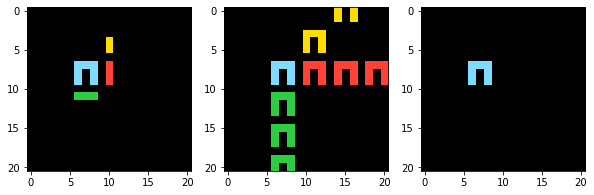

In [26]:
# Training on a single task 
task = get_task('train', 4) # just change the integer (i.e. index) tp check other tasks
train_result, train_predictions = evaluate([4])

fig, axs = plt.subplots(1, 3, figsize=(10,10))
plt.subplots_adjust(wspace=0.2, hspace=0)
axs[0].imshow(task['test'][0]['input'], cmap=cmap, norm=norm) # test input
axs[1].imshow(task['test'][0]['output'], cmap=cmap, norm=norm) # test output
axs[2].imshow(train_predictions[0][0], cmap=cmap, norm=norm) # test prediction

In [27]:
# Training on all the task in which input and output have the same shape

train_result, train_predictions = evaluate(same_shape)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")


solved : 3 from 268 (0.011194029850746268)
